# Simple dynamic seq2seq with TensorFlow

This tutorial covers building seq2seq using dynamic unrolling with TensorFlow. 

I wasn't able to find any existing implementation of dynamic seq2seq with TF (as of 01.01.2017), so I decided to learn how to write my own, and document what I learn in the process.

I deliberately try to be as explicit as possible. As it currently stands, TF code is the best source of documentation on itself, and I have a feeling that many conventions and design decisions are not documented anywhere except in the brains of Google Brain engineers. This makes learning it a bit of a guesswork, and also wickedly fun.

I hope this will be useful to people whose brains are wired like mine.

**UPDATE**: as of r1.0 @ 16.02.2017, there is new official implementation in `tf.contrib.seq2seq`. See [tutorial #3](3-seq2seq-native-new.ipynb). Official tutorial reportedly be up soon. Personally I still find wiring dynamic encoder-decoder by hand insightful in many ways.

Here we implement plain seq2seq — forward-only encoder + decoder without attention. I'll try to follow closely the original architecture described in [Sutskever, Vinyals and Le (2014)](https://arxiv.org/abs/1409.3215). If you notice any deviations, please let me know.

Architecture diagram from their paper:
![seq2seq architecutre](pictures/1-seq2seq.png)
Rectangles are encoder and decoder's recurrent layers. Encoder receives `[A, B, C]` sequence as inputs. We don't care about encoder outputs, only about the hidden state it accumulates while reading the sequence. After input sequence ends, encoder passes its final state to decoder, which receives `[<EOS>, W, X, Y, Z]` and is trained to output `[W, X, Y, Z, <EOS>]`. `<EOS>` token is a special word in vocabulary that signals to decoder the beginning of translation.

## Implementation details

TensorFlow has its own [implementation of seq2seq](https://www.tensorflow.org/tutorials/seq2seq/). Recently it was moved from core examples to [`tensorflow/models` repo](https://github.com/tensorflow/models/tree/master/tutorials/rnn/translate), and uses deprecated seq2seq implementation. Deprecation happened because it uses **static unrolling**.

**Static unrolling** involves construction of computation graph with a fixed sequence of time step. Such a graph can only handle sequences of specific lengths. One solution for handling sequences of varying lengths is to create multiple graphs with different time lengths and separate the dataset into this buckets.

**Dynamic unrolling** instead uses control flow ops to process sequence step by step. In TF this is supposed to more space efficient and just as fast. This is now a recommended way to implement RNNs.

## Vocabulary

Seq2seq maps sequence onto another sequence. Both sequences consist of integers from a fixed range. In language tasks, integers usually correspond to words: we first construct a vocabulary by assigning to every word in our corpus a serial integer. First few integers are reserved for special tokens. We'll call the upper bound on vocabulary a `vocabulary size`.

Input data consists of sequences of integers.

In [1]:
x = [[5, 7, 8], [6, 3], [3], [1]]

While manipulating such variable-length lists are convenient to humans, RNNs prefer a different layout:

In [2]:
import helpers
xt, xlen = helpers.batch(x)

In [3]:
x

[[5, 7, 8], [6, 3], [3], [1]]

In [4]:
xt

array([[5, 6, 3, 1],
       [7, 3, 0, 0],
       [8, 0, 0, 0]], dtype=int32)

Sequences form columns of a matrix of size `[max_time, batch_size]`. Sequences shorter then the longest one are padded with zeros towards the end. This layout is called `time-major`. It is slightly more efficient then `batch-major`. We will use it for the rest of the tutorial.

In [5]:
xlen

[3, 2, 1, 1]

For some forms of dynamic layout it is useful to have a pointer to terminals of every sequence in the batch in separate tensor (see following tutorials).

# Building a model

## Simple seq2seq

Encoder starts with empty state and runs through the input sequence. We are not interested in encoder's outputs, only in its `final_state`.

Decoder uses encoder's `final_state` as its `initial_state`. Its inputs are a batch-sized matrix with `<EOS>` token at the 1st time step and `<PAD>` at the following. This is a rather crude setup, useful only for tutorial purposes. In practice, we would like to feed previously generated tokens after `<EOS>`.

Decoder's outputs are mapped onto the output space using `[hidden_units x output_vocab_size]` projection layer. This is necessary because we cannot make `hidden_units` of decoder arbitrarily large, while our target space would grow with the size of the dictionary.

This kind of encoder-decoder is forced to learn fixed-length representation (specifically, `hidden_units` size) of the variable-length input sequence and restore output sequence only from this representation.

In [6]:
import numpy as np
import tensorflow as tf
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [7]:
tf.__version__

'1.0.0'

### Model inputs and outputs 

First critical thing to decide: vocabulary size.

Dynamic RNN models can be adapted to different batch sizes and sequence lengths without retraining (e.g. by serializing model parameters and Graph definitions via `tf.train.Saver`), but changing vocabulary size requires retraining the model.

In [8]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

Nice way to understand complicated function is to study its signature - inputs and outputs. With pure functions, only inputs-output relation matters.

- `encoder_inputs` int32 tensor is shaped `[encoder_max_time, batch_size]`
- `decoder_targets` int32 tensor is shaped `[decoder_max_time, batch_size]`

In [9]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

We'll add one additional placeholder tensor: 
- `decoder_inputs` int32 tensor is shaped `[decoder_max_time, batch_size]`

In [10]:
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

We actually don't want to feed `decoder_inputs` manually — they are a function of either `decoder_targets` or previous decoder outputs during rollout. However, there are different ways to construct them. It might be illustrative to explicitly specify them for out first seq2seq implementation.

During training, `decoder_inputs` will consist of `<EOS>` token concatenated with `decoder_targets` along time axis. In this way, we always pass target sequence as the history to the decoder, regrardless of what it actually outputs predicts. This can introduce distribution shift from training to prediction. 
In prediction mode, model will receive tokens it previously generated (via argmax over logits), not the ground truth, which would be unknowable.

Notice that all shapes are specified with `None`s (dynamic). We can use batches of any size with any number of timesteps. This is convenient and efficient, however but there are obvious constraints: 
- Feed values for all tensors should have same `batch_size`
- Decoder inputs and ouputs (`decoder_inputs` and `decoder_targets`) should have same `decoder_max_time`

### Encoder

The centerpiece of all things RNN in TensorFlow is `RNNCell` class and its descendants (like `LSTMCell` and `InputProjectionWrapper`). But they are outside of the scope of this post — nice [official tutorial](https://www.tensorflow.org/tutorials/recurrent/) is available. While at it, make sure you're also familiar with the [official tutorial on embeddings](https://www.tensorflow.org/tutorials/word2vec/).

`@TODO: RNNCell as a factory`

In [11]:
from tensorflow.contrib.rnn import (LSTMCell,
                                    InputProjectionWrapper,
                                    OutputProjectionWrapper)

In [12]:
encoder_cell = LSTMCell(encoder_hidden_units)

encoder_cell = InputProjectionWrapper(cell=encoder_cell, num_proj=input_embedding_size)

encoder_inputs_onehot = tf.one_hot(encoder_inputs, depth=vocab_size, dtype=tf.float32)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_onehot,
    dtype=tf.float32, time_major=True,
)

del encoder_outputs

Observe what is going on here:
- `encoder_inputs`, integer tensor with shape `[max_time, batch_size]`, gets one-hot encoded. Every integer at the every timestep in every batch gets transformed into a vector with size `vocab_size` that forms the new inner dimension. Resulting `encoder_inputs_onehot` is shaped `[max_time, batch_size, vocab_size]`. It consists of a single 1 and (vocab_size-1) 0s, but we want it to be float32 since we're going to multiply it with projection layer's weights.
- `InputProjectionWrapper` adds `[vocab_size, hidden_units]` linear projection layer (without nonlinearities) before `LSTMCell`'s inputs. Resulting projection is shaped `[max_time, batch_size, hidden_units]` and is compatible with `LSTMCell`.

There is more efficient way to get `[max_time, batch_size, hidden_units]` shape from `encoder_inputs`: `tf.nn.embedding_lookup`. Instead of one-hot encoding followed by matrix multiplication, it treats input integers as indices of projection layer's weights (this works because multiplication of one-hot vector with a dense matrix is exactly equivalent to indexing this matrix with an integer). Additionally, I think, it removes unnecessary compution of gradients for inactive embeddings (`@TODO: check, reformulate`).

We discard `encoder_outputs` because we are not interested in them within seq2seq framework. What we actually want is `encoder_final_state` — state of LSTM's hidden cells at the last moment of the Encoder rollout.

`encoder_final_state` is also called "thought vector". We will use it as initial state for the Decoder. In seq2seq without attention this is the only point where Encoder passes information to Decoder. We hope that backpropagation through time algorithm will tune the model to pass enough information in thought vector for correct output decoding.

In [13]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>)

TensorFlow LSTM implementation stores state as a tuple of tensors. 
- `encoder_final_state.h` is activations of hidden layer of LSTM cell
- `encoder_final_state.c` is final output, which can potentially be transfromed with some wrapper `@TODO: check correctness`

### Decoder

In [14]:
decoder_cell = LSTMCell(decoder_hidden_units)

decoder_cell = InputProjectionWrapper(cell=decoder_cell, num_proj=input_embedding_size)

decoder_cell = OutputProjectionWrapper(cell=decoder_cell, output_size=vocab_size)

decoder_inputs_onehot = tf.one_hot(decoder_inputs, depth=vocab_size, dtype=tf.float32)

decoder_logits, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_onehot,
    
    initial_state=encoder_final_state,

    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

decoder_prediction = tf.argmax(decoder_logits, 2)

Since we pass `encoder_final_state` as `initial_state` to the decoder, they should be compatible. This means the same cell type (`LSTMCell` in our case), the same amount of `hidden_units` and the same amount of layers (single layer). I suppose this can be relaxed if we additonally pass `encoder_final_state` through a one-layer MLP.

Decoder inputs get the same one-hot -> projection treatment as encoder inputs. But in case of the decoder, there is one more thing to do.

With encoder, we were not interested in cells output. But decoder's outputs are what we actually after: we use them to get distribution over words of output sequence.

At this point `decoder_cell` output is a `hidden_units` sized vector at every timestep. However, for training and prediction we need logits of size `vocab_size`. Reasonable thing would be to put linear layer on top of LSTM output to get non-normalized logits. This layer is called projection layer by convention.

### Optimizer

In [15]:
decoder_logits

<tf.Tensor 'plain_decoder/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 10) dtype=float32>

RNN outputs tensor of shape `[max_time, batch_size, hidden_units]` which projection layer maps onto `[max_time, batch_size, vocab_size]`. `vocab_size` part of the shape is static, while `max_time` and `batch_size` is dynamic.

In [16]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [17]:
sess.run(tf.global_variables_initializer())

### Test forward pass

Did I say that deep learning is a game of shapes? When building a Graph, TF will throw errors when static shapes are not matching. However, mismatches between dynamic shapes are often only discovered when we try to run something through the graph.


So let's try running something. For that we need to prepare values we will feed into placeholders.

```
this is key part where everything comes together

@TODO: describe
- how encoder shape is fixed to max
- how decoder shape is arbitraty and determined by inputs, but should probably be longer then encoder's
- how decoder input values are also arbitraty, and how we use GO token, and what are those 0s, and what can be used instead (shifted gold sequence, beam search)
@TODO: add references
```

In [18]:
batch_ = [[6], [3, 4], [9, 8, 7]]
batch_, batch_length_ = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = helpers.batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[9 9 0]
 [7 5 7]
 [7 5 7]
 [7 5 7]]


Successful forward computation, everything is wired correctly.

## Training on the toy task

We will teach our model to memorize and reproduce input sequence. Sequences will be random, with varying length.

Since random sequences do not contain any structure, model will not be able to exploit any patterns in data. It will simply encode sequence in a thought vector, then decode from it.

In [19]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[7, 5, 8, 7, 8, 7, 3, 3]
[3, 3, 4, 9]
[4, 8, 5, 3]
[2, 4, 9, 5, 2, 2, 6, 3]
[9, 4, 9, 9, 3, 9, 9]
[6, 9, 3]
[8, 6, 2, 6]
[5, 3, 7]
[6, 2, 2, 8, 2, 2, 2, 5]
[2, 3, 3, 3, 5, 3, 4]


In [20]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    decoder_inputs_, _ = helpers.batch(
        [[EOS] + (sequence) + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [21]:
loss_track = []

In [22]:
max_batches = 10000
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.32193660736084
  sample 1:
    input     > [5 5 4 5 5 0 0 0]
    predicted > [7 1 1 1 1 1 3 3 3 3 3]
  sample 2:
    input     > [4 9 4 0 0 0 0 0]
    predicted > [9 9 9 7 7 7 3 3 3 3 3]
  sample 3:
    input     > [5 7 3 9 2 8 9 0]
    predicted > [9 1 0 8 8 9 8 8 5 5 5]

batch 1000
  minibatch loss: 0.2657450735569
  sample 1:
    input     > [4 9 5 6 0 0 0 0]
    predicted > [4 9 5 6 1 0 0 0 0 0 0]
  sample 2:
    input     > [6 7 4 6 6 7 9 3]
    predicted > [6 7 6 6 6 7 9 3 1 0 0]
  sample 3:
    input     > [4 3 8 0 0 0 0 0]
    predicted > [3 3 8 1 0 0 0 0 0 0 0]

batch 2000
  minibatch loss: 0.15436933934688568
  sample 1:
    input     > [9 7 2 6 6 0 0 0]
    predicted > [9 7 2 6 6 1 0 0 0 0 0]
  sample 2:
    input     > [5 7 2 6 2 0 0 0]
    predicted > [5 7 2 6 2 1 0 0 0 0 0]
  sample 3:
    input     > [3 3 8 0 0 0 0 0]
    predicted > [3 3 8 1 0 0 0 0 0 0 0]

batch 3000
  minibatch loss: 0.0975458025932312
  sample 1:
    input     > [5 2 3 8 7

loss 0.0346 after 1000000 examples (batch_size=100)


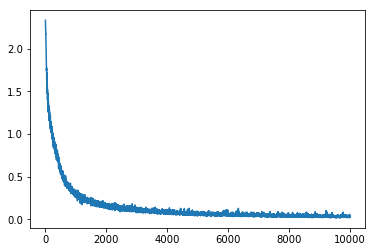

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

Something is definitely getting learned.

# Limitations of the model

We have no control over transitions of `tf.nn.dynamic_rnn`, it is unrolled in a single sweep

- can't use beam search decoder optimization
- can't feed previously generated tokens without falling back to python loops
- can't use attention, because attention conditions decoder inputs on its previous state

Solution would be to use `tf.nn.raw_rnn` to reimplement relevant parts of `tf.nn.dynamic_rnn`, add attention and beam search loops.
**Will be done in following tutorials.**

# Fun things to try (aka Exercises)

- In `copy_task` increasing `max_sequence_size` and `vocab_upper`. Observe slower learning and general performance degradation.

- For `decoder_inputs`, instead of shifted target sequence `[<EOS> W X Y Z]`, try feeding `[<EOS> <PAD> <PAD> <PAD>]`, like we've done when we tested forward pass. Does it break things? Or slows learning?